In [584]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [350]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [920]:
path = "boneage_preds_0.6"
with open("../../../../" + path, 'rb') as f:
    data = pickle.load(f)

In [921]:
preds_adv_on_1 = data['preds_adv_on_1']
preds_adv_on_2 = data['preds_adv_on_2']
preds_vic_on_1 = data['preds_vic_on_1']
preds_vic_on_2 = data['preds_vic_on_2']

In [922]:
def KL(a, b):
    a_, b_ = 1 - a, 1 - b
    first = a * (np.log(a) - np.log(b))
    second = a_ * (np.log(a_) - np.log(b_))
    together = first + second
    return np.mean(together, 1) # Technique 2
    # return np.mean(together)  # Technique 1

In [923]:
def pairwise_compare(x, y, xx, yy):
    x_ = np.expand_dims(x, 2)
    y_ = np.expand_dims(y, 2)
    y_ = np.transpose(y_, (0, 2, 1))
#     pairwise_comparisons = (x_ > y_) # Standard voting
    pairwise_comparisons = (x_ - y_) # Blind voting
    # Get unique pairs (ignore self)
    preds = np.array([z[xx, yy] for z in pairwise_comparisons])
    return preds

In [924]:
def main_stuff(ka, kb, kc1, kc2, frac):
    ka_ = sigmoid(ka)
    kb_ = sigmoid(kb)
    kc1_ = sigmoid(kc1)
    kc2_ = sigmoid(kc2)
    
    # Pick data from ka_ and kb_ that leads to highest 'entropy' between the two distributions
#     diff = np.argsort(-np.mean(np.abs(ka_ - kb_), 0))
#     # Pick the top 80% of data
#     frac_data = 0.9
#     diff = diff[:int(len(diff) * frac_data)]
#     ka_, kb_ = ka_[:, diff], kb_[:, diff]
#     kc1_, kc2_ = kc1_[:, diff], kc2_[:, diff]

    # Randomly pick pairs of models
    xx, yy = np.triu_indices(ka.shape[0], k=1)
    random_pick = np.random.permutation(xx.shape[0])[:int(frac * xx.shape[0])]
    xx, yy = xx[random_pick], yy[random_pick]
    
    KL_vals_1_a = np.array([KL(ka_, x) for x in kc1_])
    KL_vals_1_b = np.array([KL(kb_, x) for x in kc1_])
    KL_vals_2_a = np.array([KL(ka_, x) for x in kc2_])
    KL_vals_2_b = np.array([KL(kb_, x) for x in kc2_])

    # Technique 1: Aggregate KL value across all data and models, and then compare
    # preds_first = np.mean(KL_vals_1_a < KL_vals_1_b)
    # preds_second = np.mean(KL_vals_2_b < KL_vals_2_a)
    
    # Technique 2: Aggregate KL value across all data per adv model pair (m0[i], m1[i]), then vote
    # Could technically consider all nC2 pairs, but can try that later
    # This approach seems to work better in my experiments on BoneAge
    
    # Use only 'some' pairs for preds
    # preds_first = np.mean(KL_vals_1_a > KL_vals_1_b, 1)
    # preds_second = np.mean(KL_vals_2_a > KL_vals_2_b, 1)
    
    preds_first = pairwise_compare(KL_vals_1_a, KL_vals_1_b, xx, yy)
    preds_second = pairwise_compare(KL_vals_2_a, KL_vals_2_b, xx, yy)
    return preds_first, preds_second
    
#     gt = np.concatenate((np.zeros_like(preds_first), np.ones_like(preds_second)))
#     acc = np.mean((preds >= 0.5) == gt)

In [925]:
def combined_main_stuff(adv_1, adv_2, vic_1, vic_2, frac: float = 0.3):
    # Call and get preds from first data
    preds_1_first, preds_1_second = main_stuff(adv_1.preds_property_1,
                         adv_1.preds_property_2,
                         vic_1.preds_property_1,
                         vic_1.preds_property_2,
                         frac)
    # Call and get preds from second data
    preds_2_first, preds_2_second = main_stuff(adv_2.preds_property_1,
                         adv_2.preds_property_2,
                         vic_2.preds_property_1,
                         vic_2.preds_property_2,
                         frac)
    # Concatenate
    preds_first = np.concatenate((preds_1_first, preds_2_first), 1)
    preds_second = np.concatenate((preds_1_second, preds_2_second), 1)
    preds = np.concatenate((preds_first, preds_second))
    
    # Weighted voting
    preds_ = preds - np.min(preds, 0)
    preds_ /= np.max(preds_, 0)
    preds_ = np.mean(preds_, 1)
    
    # Blind Voting
    preds = np.mean(preds > 0, 1)
    gt = np.concatenate((np.zeros(preds_first.shape[0]), np.ones(preds_second.shape[0])))
    acc = np.mean((preds >= 0.5) == gt)
    acc_ = np.mean((preds_ >= 0.5) == gt)
    return acc, acc_

In [931]:
combined_main_stuff(preds_adv_on_1, preds_adv_on_2, preds_vic_on_1, preds_vic_on_2, frac=0.8)

(0.596, 0.638)

In [927]:
fracs = np.linspace(0.1, 1.0, 10)
accs, accs_ = [], []
for frac in tqdm(fracs):
    trial, trial_  = [], []
    for _ in range(3):
        acc, acc_ = combined_main_stuff(preds_adv_on_1, preds_adv_on_2, preds_vic_on_1, preds_vic_on_2, frac=frac)
        trial.append(acc)
        trial_.append(acc_)
    accs.append(np.mean(trial))
    accs_.append(np.mean(trial_))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.38s/it]


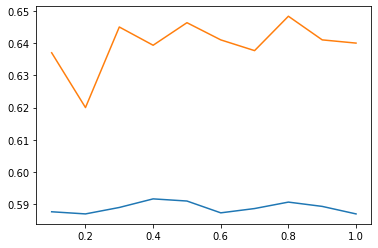

In [928]:
plt.plot(fracs, accs)
plt.plot(fracs, accs_)